In [3]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from datetime import datetime
import mplfinance as mpf
from collections import defaultdict
from datetime import timedelta
from Backtest_source import *
import talib as ta
import shutil
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from tslearn.clustering import TimeSeriesKMeans

pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=3, suppress=True)

# Manual Extreme

In [16]:
class Strategy_Volatility_new(Strategy):
    def __init__(self, data_hr, strategy_list=['base']):
#         self.data_d = data_d
        self.data_hr = data_hr
#         self.run_time = run_time
#         self.name = name
        self.strategy_list = strategy_list
#         self.trading_fee = trading_fee
        self.list_variable = list(data_hr.columns)
#         self.run_time = datetime.now().strftime("%Y%m%d%H%M")

    def input_signal_pat(self, data):
        data.reset_index(drop=True, inplace=True)
        array_day = np.array([int(str(i)[:8]) for i in data['date']])
        array_time = np.array([int(str(i)[8:]) for i in data['date']])

        smoothing = 10
        extreme = 3
#        data.index = [datetime.strptime(str(i),'%Y%m%d%H%M') for i in data.date]
        data = add_extreme(data, smoothing, extreme)
#         print(data)
        index_pat = find_pattern(data)
#         print(index_pat)
        data.loc[index_pat, ['buy_signal']] = 1
        data['buy_signal'] = np.where(data['buy_signal'].shift(extreme+1)==1, 1, 0)
#         data['sell_signal'] = np.where(array_time == 1530, 1, 0)
        data['sell_signal'] = data['buy_signal'].shift(12)
        data['sell_signal'] = np.where((data['buy_signal']==1)|(array_time==1530), 1, 0)
        data['open_adj'] = data['open']
        data['close_adj'] = data['close']

        return data[['date','code_stock','open','high','low','close','open_adj','close_adj','buy_signal','sell_signal']].to_numpy().astype(np.int64)


    def output_status(self, data):
        array_status = np.where(np.roll(data[:,9], 1)==1, 0, np.where(data[:,8]==1, 1, np.nan))
        array_status_fill = fill_nan_with_last(array_status)
        return np.c_[data, array_status_fill.reshape(-1,1)]

    def cal_return(self, data):
        data[:,6] = np.where((data[:,10]==1)&(np.roll(data[:,10], 1)==0), data[:,6], data[:,2])
        data[:,7] = np.where((data[:,10]==1)&(np.roll(data[:,10], -1)==0), data[:,7], data[:,5])
        return data

      
    def calculate(self, run_time):
        data_raw = self.data_hr
        self.run_time = run_time
        for strategy in self.strategy_list:
            if 'total' in strategy:
                if 'pat' in strategy:
                    data_raw = self.input_signal_pat(data_raw)
#                     self.data_temp = data_raw
#                     print(data_raw)
                    data_raw = self.output_status(data_raw)
#                     self.data_temp2 = data_raw
#                     print(data_raw)
                    data_hr = self.cal_return(data_raw)
#                     print(data_hr)
        from_file_path = './Cal.ipynb' # 복사할 파일
        to_file_path = f'./result/{self.run_time}_code.ipynb' # 복사 위치 및 파일 이름 지정
        shutil.copyfile(from_file_path, to_file_path)
        return data_hr

In [20]:
date_start = datetime(2017,1,1,9)
date_end = datetime(2022,1,1,9)
stock_code = ['000220']
# stock_code = ['000220','000660']
case2 = Backtest_Stocks(date_start,date_end,stock_code,timeframe='minute5',option='pd')
case2.input_strategy(Strategy_Volatility_new,[f'total, pat'])
case2.trading_fee = 0.2
# name = 'dip'
case2.cal_strategy('pat')

df_all = case2.analyze_result_time1(name='pat',max_profit=True)
# summarize_result(df_all)

In [18]:
summarize_result(df_all)
# plot_trade(df_all[374])

'승률 : 15.40, 손익비 : 0.86  / 1266 (-0.22) / 195 (0.26) / 1071 (-0.30)'

In [3]:
def summarize_result(df_all):
    return_all = df_all[:,2]
    count = len(return_all)
    cnt_p = len(return_all[return_all>0])
    cnt_n = len(return_all[return_all<0])
    rtn_p = return_all[return_all>0].mean()
    rtn_n = return_all[return_all<0].mean()
    result = f'승률 : {cnt_p/count*100:.2f}, 손익비 : {-rtn_p/rtn_n:.2f}  / {count} ({return_all.mean()*100:.2f}) / {cnt_p} ({rtn_p*100:.2f}) / {cnt_n} ({rtn_n*100:.2f})'
    return result
def plot_trade(result_trade, save=False, timeframe='5m'):
    if timeframe == '5m':
        count_per_day = 79
        file_loc = './data/5m'
    elif timeframe == '1m':
        count_per_day = 399
        file_loc = './data/1m'
    
    code_coin = str(int(result_trade[3])).zfill(6)
    datetime_start = datetime.strptime(str(int(result_trade[0])),'%Y%m%d%H%M')
    date_start = datetime_start.replace(hour=9, minute=0)
    date_end = datetime_start.replace(hour=15, minute=30)
    datetime_end = datetime.strptime(str(int(result_trade[1])),'%Y%m%d%H%M')
    file_name = f'{file_loc}/A{code_coin}.csv'
    file = pd.read_csv(file_name, index_col=0)
    file.sort_values(by='date', ascending=True, inplace=True)
    file.reset_index(inplace=True,drop=True)
    file.index = list(file.index)
    first_index = file.index[(file['date']==int(result_trade[0]))][0]
    last_index = file.index[(file['date']==int(result_trade[1]))][0]
    file = file.iloc[first_index-count_per_day:last_index+count_per_day]
    file.index = [datetime.strptime(str(i),'%Y%m%d%H%M') for i in file.date]

    data = file[['open','high','low','close','volume']]
    file.loc[datetime_start, ['buy']] = result_trade[4]
    file.loc[datetime_end, ['sell']] = result_trade[5]
    buy_marker = mpf.make_addplot(file['buy'] , type='scatter', marker='>', markersize=10, panel=0)
    sell_marker = mpf.make_addplot(file['sell'] , type='scatter', marker='<', markersize=10, panel=0)
    rsi = ta.RSI(file['high']-file['close'], timeperiod=12)
    rsi_line = mpf.make_addplot(rsi)
    addplot = [buy_marker, sell_marker]
# ta.
    vlines = dict(vlines=[date_start,date_end],linewidths=(1,1), alpha=0.5)
    fb_color = 'b' if result_trade[4] < result_trade[5] else 'r'
    fb_range = dict(y1=result_trade[4], y2=result_trade[5], color=fb_color, alpha=0.2)

#     if save:
    savefile_name = f'./result/picture/{datetime.now().strftime("%Y%m%d%H%M")}_{code_coin}_{int(result_trade[0])}.png'
#         mpf.plot(data, type='candle', style='yahoo', addplot=addplot, title=f'{code_coin}', volume=True, vlines=dict(vlines=[date_start,date_end],linewidths=(1,1)),savefig=savefile_name, figscale=0.7, fill_between=dict(y1=result_trade[4], y2=result_trade[5]))
#     else:
#         mpf.plot(data, type='candle', style='yahoo', addplot=addplot, title=f'{code_coin}', volume=True, vlines=vlines, fill_between=fb_range)
    fig, axes = mpf.plot(data, type='candle', style='yahoo', addplot=addplot,  volume=True, vlines=vlines, fill_between=fb_range, returnfig=True)
#     axes[0].legend('aa')
    axes[0].set_title(f'{code_coin}')
    if save:
        fig.savefig(savefile_name)
    else:
        fig.show()
def add_extreme(data, smoothing, extreme):
    data['tuned_price'] = ta.EMA(data['high'], smoothing)
#     data['tuned_price'] = ta.EMA((data['high']+data['low']+data['close'])*data['volume'], smoothing)

    #     data['close'].rolling(window=smoothing).mean()
    n = extreme  # number of points to be checked before and after

    data['ex_min'] = data.iloc[argrelextrema(data.tuned_price.values, np.less_equal, order=n)[0]]['tuned_price']
    data['ex_max'] = data.iloc[argrelextrema(data.tuned_price.values, np.greater_equal, order=n)[0]]['tuned_price']
    data['ex'] = np.where(np.isnan(data['ex_min']), data['ex_max'], data['ex_min'])
    return data
def unique_seq(ar):
    _, ar_loc, ar_count = np.unique(ar, axis=0, return_inverse=True, return_counts=True)
    _, index = np.unique(ar_loc, return_index=True)
    return np.array([ar_count[ar_loc[i]] for i in np.sort(index)])
def find_pattern(data):  
    patterns = defaultdict(list)
    max_min = data['ex'].dropna()

    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        if np.busday_count(data.loc[window.index[0], 'date'], data.loc[window.index[-1], 'date']) >= 10000:
#             print(data.loc[window.index[0], 'date'], data.loc[window.index[-1], 'date'])
            #         if window.index[-1] - window.index[0] > 100: #100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
        
        # IHS
        cond_IHS1 = a < b
        cond_IHS2 = (c<a)&(c<e)&(c<d)&(e<d)
        cond_IHS3 = (abs(a-e)<=np.mean([a,e])*0.03)&(abs(b-d)<=np.mean([b,d])*0.03)
        if cond_IHS1&cond_IHS2&cond_IHS3:
#             patterns['IHS'].append((window.index[0], window.index[-1]))
            patterns['IHS'].append(window.index[-1])
        # IHS
#         if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
#             patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns['IHS']
def fill_nan_with_last(arr):
    prev = np.arange(len(arr))
    prev[np.isnan(arr)] = 0
    prev = np.maximum.accumulate(prev)
    return arr[prev]

# Sklearn clustering

In [7]:
def index_to_time(ind):
    return 900 + (ind//12)*100 + (ind%12)*5
def time_to_index(time):
    return ((time-900)//100)*12 + ((time%100)//5)

In [4]:
files = Path("./data/5m_modi/").rglob("*.csv")
files = [str(i)[-10:-4] for i in files if str(i)[-5] == '0' ]

In [21]:
ar_train_input, ar_test_input_high, ar_train_result, ar_test_result = split_data(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, price_method='high_ema', train_method='daily_close')
model_high, label_arg_index_high, rtnh1, rtnh2, rtnh3 = generate_model(ar_train_input, ar_train_result)
# ar_train_input, ar_test_input_low, ar_train_result, ar_test_result = split_data(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, price_method='low_ema', train_method='daily_close')
# model_low, label_arg_index_low, rtnl1, rtnl2, rtnl3 = generate_model(ar_train_input, ar_train_result)

# return_base = [date_trade.strftime('%y%m%d'), time_buy, rtnh1, rtnh2, rtnh3, rtnl1, rtnl2, rtnl3]

# list_model = [model_high,model_low]
# list_model = [model_high]
# list_label = [label_arg_index_high[:int((label_arg_index_high.max()+1)/10)]]
# list_test_input = [ar_test_input_high]

# list_label = [label_arg_index_high[:int((label_arg_index_high.max()+1)/10)], label_arg_index_low[:int((label_arg_index_low.max()+1)/10)]]
# list_test_input = [ar_test_input_high, ar_test_input_low]

# return_temp = evaluate_model(list_model, list_label, list_test_input, ar_test_result)

# return_base[len(return_base):] = return_temp

In [ ]:
from tslearn.clustering import silhouette_score

silhouette_score(ar_train_input, model_high.labels_)

In [18]:
stock_codes = files[:100]
return_all = []
for i in range(1,5):
# i=6
    date_trade = datetime(2022, i, 1)
    print(date_trade.strftime('%y%m%d'))
    month_train = 3
    month_test = 1
    date_train_start = date_trade - relativedelta(months=month_train)
#     date_test_end = date_trade + relativedelta(months=month_test)
    date_test_end = date_trade + relativedelta(days=10)
    date_data_start = date_train_start - relativedelta(days=7)
    date_data_end = date_test_end + relativedelta(days=7)
    # time_buy = 1200

    case_clu = Backtest_Stocks(date_data_start,date_data_end,stock_codes,timeframe='minute5',option='pd')
    for j in tqdm(range(5,50)):
    # i=25
        time_buy = index_to_time(j)
#         return_base = [date_trade.strftime('%y%m%d'), time_buy]
#         ar_train_input, ar_test_input, ar_train_result, ar_test_result = split_data(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, price_method='close_ema', train_method='daily_close')
#         model_close, label_arg_index_close = generate_model(ar_train_input, ar_train_result)
        ar_train_input, ar_test_input_high, ar_train_result, ar_test_result = split_data(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, price_method='high_ema', train_method='daily_close')
        model_high, label_arg_index_high, rtnh1, rtnh2, rtnh3 = generate_model(ar_train_input, ar_train_result)
        ar_train_input, ar_test_input_low, ar_train_result, ar_test_result = split_data(case_clu.data_raw, date_trade, date_train_start, date_test_end, time_buy, price_method='low_ema', train_method='daily_close')
        model_low, label_arg_index_low, rtnl1, rtnl2, rtnl3 = generate_model(ar_train_input, ar_train_result)

        return_base = [date_trade.strftime('%y%m%d'), time_buy, rtnh1, rtnh2, rtnh3, rtnl1, rtnl2, rtnl3]

        list_model = [model_high,model_low]
        list_label = [label_arg_index_high[:int((label_arg_index_high.max()+1)/10)], label_arg_index_low[:int((label_arg_index_low.max()+1)/10)]]
        list_test_input = [ar_test_input_high, ar_test_input_low]

        return_temp = evaluate_model(list_model, list_label, list_test_input, ar_test_result)

        return_base[len(return_base):] = return_temp
        return_all.append(return_base)


220101


  0%|                                                                  | 0/45 [02:59<?, ?it/s]


KeyboardInterrupt: 

In [34]:
pd.DataFrame(return_all).to_csv('./result_hl_ema_new_ts.csv')

In [20]:
def split_data(data, date_trade, date_train_start, date_test_end, time_buy, price_method='close', train_method='daily_close'):
    array_date = np.array(data['date'])
    array_close = np.array(data['close'])
    array_code = np.array(data['code_stock']).astype(np.int32)
    array_day = np.array([int(str(i)[:8]) for i in array_date])
    array_time = np.array([int(str(i)[8:]) for i in array_date])

    period = 20
    if price_method == 'close':
        ar_price = np.array(case_clu.data_raw['close'])
    elif price_method == 'close_sma':
        ar_price = ta.SMA(case_clu.data_raw['close'], period)
    elif price_method == 'close_ema':
        ar_price = ta.EMA(case_clu.data_raw['close'], period)
    elif price_method == 'high':
        ar_price = np.array(case_clu.data_raw['high'])
    elif price_method == 'high_sma':
        ar_price = ta.SMA(case_clu.data_raw['high'], period)
    elif price_method == 'high_ema':
        ar_price = ta.EMA(case_clu.data_raw['high'], period)
    elif price_method == 'low':
        ar_price = np.array(case_clu.data_raw['low'])
    elif price_method == 'low_sma':
        ar_price = ta.SMA(case_clu.data_raw['low'], period)
    elif price_method == 'low_ema':
        ar_price = ta.EMA(case_clu.data_raw['low'], period)

    ind_time_train_end = time_to_index(time_buy)-1
    len_train = ind_time_train_end + 78

    ar_factor = np.array([1-np.sin(i/(len_train-2)*np.pi)/1.5 for i in range(len_train-1)])
    ar_price_acc = np.array([np.roll(ar_price, i+1) for i in range(len_train)]).T
    ar_price_acc = np.diff(ar_price_acc) / ar_price_acc[:,:-1] * 100 * ar_factor.reshape(1,-1)
    ar_price_norm = ar_price_acc / np.linalg.norm(ar_price_acc, axis=1).reshape(-1,1)
    ar_price_norm[np.isnan(ar_price_norm)] = 0  #전체 값이 0인 경우에는 0/0이므로 nan이 입력되며 이를 0으로 수정.

    day_train_start = int(date_train_start.strftime('%Y%m%d'))
    day_train_end = int(date_test_end.strftime('%Y%m%d'))
    day_train_base = int(date_trade.strftime('%Y%m%d'))
    
    cond_common_train = (array_time==time_buy)
    cond_common_test = (array_time==time_buy)&(array_close<=10000)&(array_close>=1000)
    
    ar_train_input = ar_price_norm[cond_common_train&(array_day <= day_train_base)&(array_day > day_train_start)]
    ar_test_input = ar_price_norm[cond_common_test&(array_day > day_train_base)&(array_day <= day_train_end)]

# high/low ratio              
    if train_method == 'daily_close':
        ar_return = np.array([array_close, np.roll(array_close, ind_time_train_end+1-78)]).T
        ar_return = np.diff(ar_return) / ar_return[:,:-1] * 100
    elif train_method == 'holding_1hr':
        ar_return = np.array([array_close, np.roll(array_close, -6)]).T
        ar_return = np.diff(ar_return) / ar_return[:,:-1] * 100
    ar_train_result = ar_return[cond_common_train&(array_day <= day_train_base)&(array_day > day_train_start)]
    ar_test_result = ar_return[cond_common_test&(array_day > day_train_base)&(array_day <= day_train_end)]

    return ar_train_input, ar_test_input, ar_train_result, ar_test_result

def generate_model(ar_train_input, ar_train_result):
    n_clusters = 30
#     model = KMeans(n_clusters=n_clusters,random_state=1)
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw",max_iter=3, random_state=1)
#     print(ar_train_input.shape, ar_train_result.shape)
    ar_train_input, ar_train_input_val = np.split(ar_train_input, [int(len(ar_train_input)/4*3)], axis=0)
    ar_train_result, ar_train_result_val = np.split(ar_train_result, [int(len(ar_train_result)/4*3)], axis=0)

    model.fit(ar_train_input)
    count_label = max(model.labels_)+1
    
#     print(ar_train_input.shape, ar_train_result.shape)
    
    label_train_result = np.array([ar_train_result[model.labels_==i].mean() for i in range(count_label)])  #label마다 train결과
    label_arg_index = label_train_result.argsort()[::-1]  # 내림차순으로 순서, 0 가장 우수
    label_arg_index_up = label_arg_index[:int((label_arg_index.max()+1)/10)]

    predict_val = model.predict(ar_train_input_val)
    label_val_result = np.array([ar_train_result_val[predict_val==i].mean() for i in range(count_label)])

    lr = LinearRegression()
    train_return_slope = lr.fit(np.arange(count_label).reshape(-1,1), label_val_result[label_arg_index].reshape(-1,1)).coef_[0][0]
    cond_up = np.any(np.array([predict_val==i for i in label_arg_index_up] ) )
    ar_up = ar_train_result_val[cond_up]

    return model, label_arg_index_up, train_return_slope, len(ar_up[ar_up>0])/(len(ar_up)+0.00001), -ar_up[ar_up>0].mean()/ar_up[ar_up<0].mean()

def evaluate_model(models, label_arg_indexes, ar_test_inputs, ar_test_result):
    cond_base = True
    for model, label_arg_index, ar_test_input in zip(models, label_arg_indexes, ar_test_inputs):
        predict = model.predict(ar_test_input)
        cond_temp = np.any(np.array([predict==i for i in label_arg_index]),axis=0)
        cond_base = cond_base*cond_temp
    ar_up = ar_test_result[cond_base]
    list_result_temp = [len(ar_up[ar_up>0])/(len(ar_up)+0.00001), -ar_up[ar_up>0].mean()/ar_up[ar_up<0].mean(), len(ar_up), ar_up.mean(), len(ar_up[ar_up>0]), ar_up[ar_up>0].mean(), len(ar_up[ar_up<0]), ar_up[ar_up<0].mean()]
    return list_result_temp

In [137]:
def reading_csv_int(file_name, datetime_start, datetime_end):
    file = pd.read_csv(file_name, index_col=0)
    file.sort_values(by='date', ascending=True, inplace=True)
    file = file[(file['date'] >= datetime_start) & (
                file['date'] <= datetime_end)]
    file['code_stock'] = str(file_name)[-10:-4]
#     if len(file)%79 == 0:
    return file[['date','time','open','high','low','close','volume','value','code_stock']]

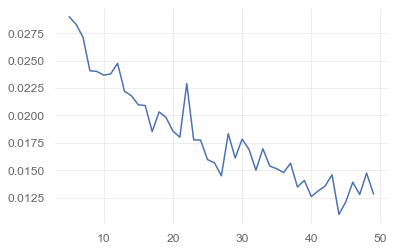

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
score = []
for i in range(5,50):
    km = KMeans(n_clusters=i)
    km.fit(ar_train_input)
    average_score = silhouette_score(ar_train_input, km.labels_)
    score.append(average_score)
plt.plot(range(5,50), score)


0.8051652496411437


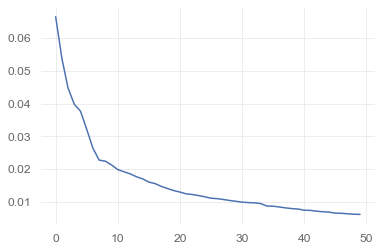

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(ar_train_input)
data_pca = pca.transform(ar_train_input)
print(np.sum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
